# Esophagitis Severity Classification (2 Classes)

### Download and extract the Dataset.

In [ ]:
!mkdir kvasir
!wget --no-check-certificate 'https://pern-my.sharepoint.com/:u:/g/personal/m21f0034ai010_fecid_paf-iast_edu_pk/ETUX9oiTyy1Dobrv87loEoQB8DTIkZpeCpZdhyGgW9a5MQ?e=9GwedY&download=1' -O esophagitis-severity.zip
!unzip /content/esophagitis-severity.zip
!mv /content/content/kvasir/labeled-images/upper-gi-tract/pathological-findings /content/kvasir
!rm -r /content/content

--2024-01-08 15:54:58--  https://pern-my.sharepoint.com/:u:/g/personal/m21f0034ai010_fecid_paf-iast_edu_pk/ETUX9oiTyy1Dobrv87loEoQB8DTIkZpeCpZdhyGgW9a5MQ?e=9GwedY&download=1
Resolving pern-my.sharepoint.com (pern-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to pern-my.sharepoint.com (pern-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/m21f0034ai010_fecid_paf-iast_edu_pk/Documents/MS%20AI/4-Spring%202023/Data/esophagitis-severity.zip?ga=1 [following]
--2024-01-08 15:54:59--  https://pern-my.sharepoint.com/personal/m21f0034ai010_fecid_paf-iast_edu_pk/Documents/MS%20AI/4-Spring%202023/Data/esophagitis-severity.zip?ga=1
Reusing existing connection to pern-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 435304862 (415M) [application/x-zip-compressed]
Saving to: ‘esophagitis-severity.zip’

esophagitis-severit 100%[===================>] 415.14M  73.1

## Verify data directories

In [ ]:
!ls /content/kvasir/pathological-findings

esophagitis-a  esophagitis-b-d


In [ ]:
#import libraries

import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dropout,Dense,Flatten,MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
import os

In [ ]:
#dataset path

dataset_directory = "/content/kvasir/pathological-findings"

## Creating Random Train and Validation Splits

In [ ]:
# train-test-splits
training_data = tf.keras.preprocessing.image_dataset_from_directory(dataset_directory,
                                                               labels="inferred",
                                                               image_size=(299, 299),
                                                               batch_size=16,
                                                               subset="training",
                                                               validation_split=0.222222,
                                                               seed=123
                                                               )

validation_data = tf.keras.preprocessing.image_dataset_from_directory(dataset_directory,
                                                              labels="inferred",
                                                              image_size=(299, 299),
                                                              batch_size=16,
                                                              subset="validation",
                                                              validation_split=0.222222,
                                                              seed=123
                                                              )

Found 597 files belonging to 2 classes.
Using 465 files for training.
Found 597 files belonging to 2 classes.
Using 132 files for validation.


In [ ]:
#classes labels

print(len(training_data.class_names), "Classes are:", training_data.class_names)

2 Classes are: ['esophagitis-a', 'esophagitis-b-d']


## Visualization

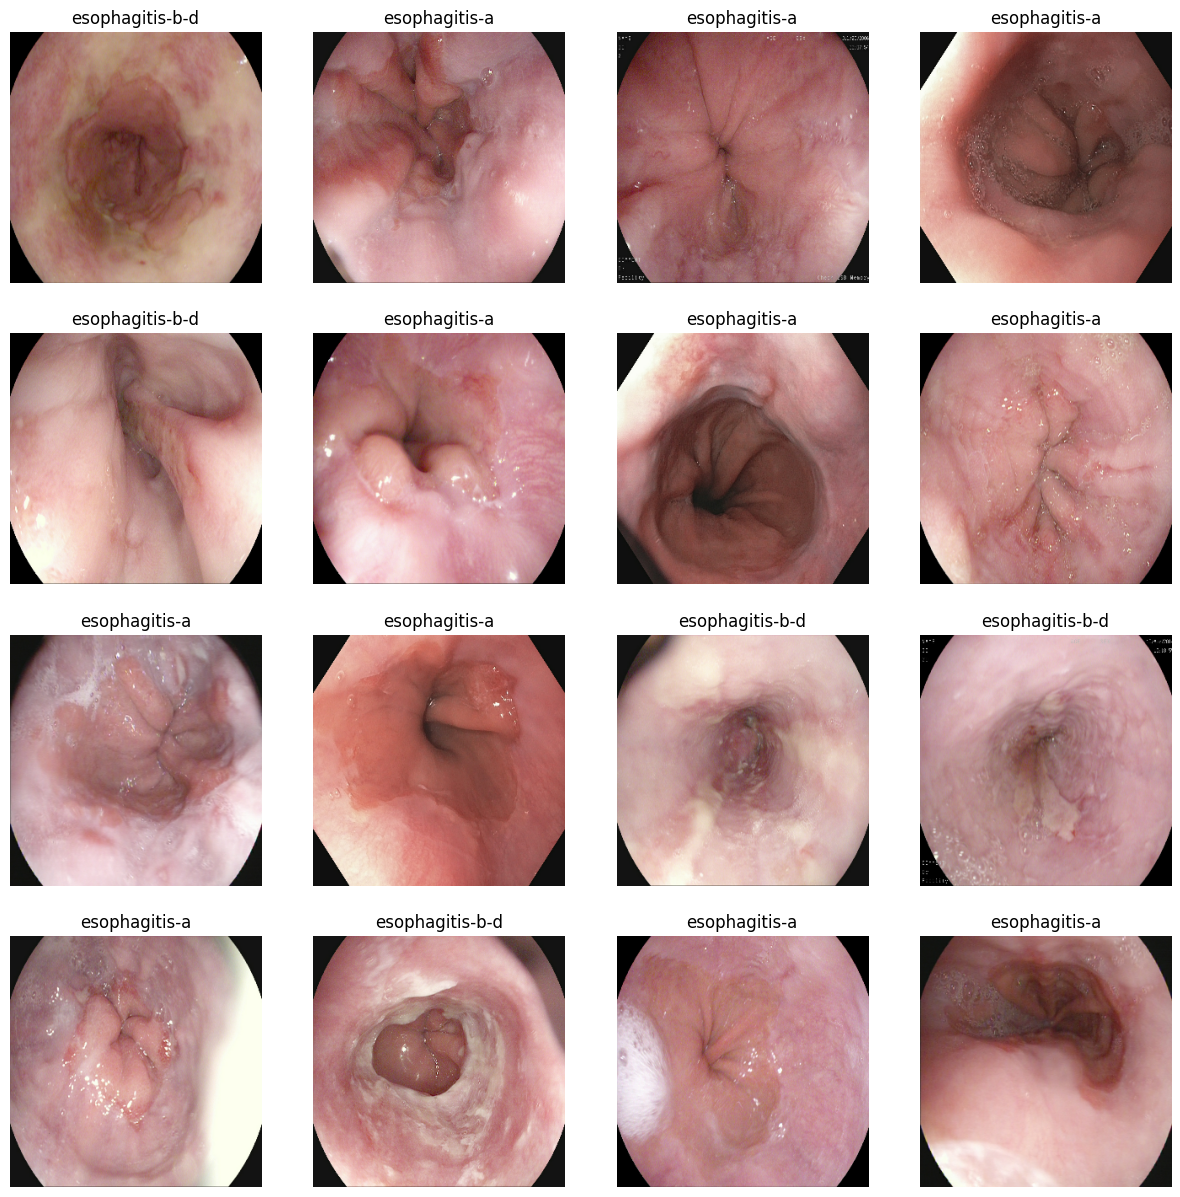

In [ ]:
#image plot

plt.figure(figsize=(15, 15))
for images, labels in training_data.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(training_data.class_names[labels[i]])
    plt.axis('off')

In [ ]:
import os
from sklearn.model_selection import train_test_split

# Get the list of class names
class_names = os.listdir(dataset_directory)
num_classes = len(class_names)

# Initialize dictionaries to store the counts for each class
training_counts = {class_name: 0 for class_name in class_names}
validation_counts = {class_name: 0 for class_name in class_names}

# Iterate over the dataset directory to count the images for each class
for class_name in class_names:
    class_directory = os.path.join(dataset_directory, class_name)
    file_names = os.listdir(class_directory)
    num_files = len(file_names)

    # Split the file names into training and validation sets
    train_files, validation_files = train_test_split(file_names, test_size=0.2, random_state=123)

    # Update the counts for training and validation sets
    training_counts[class_name] = len(train_files)
    validation_counts[class_name] = len(validation_files)

# Print the number of images for each class in the training set
print("Training Set:")
for class_name, count in training_counts.items():
    print(f"Class: {class_name}, Count: {count}")

# Print the number of images for each class in the validation set
print("Validation Set:")
for class_name, count in validation_counts.items():
    print(f"Class: {class_name}, Count: {count}")

Training Set:
Class: esophagitis-a, Count: 290
Class: esophagitis-b-d, Count: 187
Validation Set:
Class: esophagitis-a, Count: 73
Class: esophagitis-b-d, Count: 47


In [ ]:
training_data.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Model Architecture and Training

In [ ]:
num_classes = len(training_data.class_names)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", input_shape=(299, 299, 3)))
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dense(units=num_classes, activation="softmax"))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)


from tensorflow.keras.callbacks import ModelCheckpoint

# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint('best_model.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)
epochs = 50

history = model.fit(training_data,
                    validation_data = validation_data,
                    epochs = epochs,
                    callbacks=[checkpoint])

Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 83.6057 - accuracy: 0.5226
Epoch 1: val_accuracy improved from -inf to 0.60606, saving model to best_model.keras
30/30 [==============================] - 16s 289ms/step - loss: 83.6057 - accuracy: 0.5226 - val_loss: 0.7163 - val_accuracy: 0.6061
Epoch 2/50
29/30 [============================>.] - ETA: 0s - loss: 0.6890 - accuracy: 0.6013
Epoch 2: val_accuracy improved from 0.60606 to 0.62121, saving model to best_model.keras
30/30 [==============================] - 8s 225ms/step - loss: 0.6895 - accuracy: 0.6000 - val_loss: 0.6581 - val_accuracy: 0.6212
Epoch 3/50
29/30 [============================>.] - ETA: 0s - loss: 0.6609 - accuracy: 0.6142
Epoch 3: val_accuracy did not improve from 0.62121
30/30 [==============================] - 8s 189ms/step - loss: 0.6605 - accuracy: 0.6151 - val_loss: 0.6759 - val_accuracy: 0.6061
Epoch 4/50
29/30 [============================>.] - ETA: 0s - loss: 0.6690 - accuracy: 0.5991
Ep

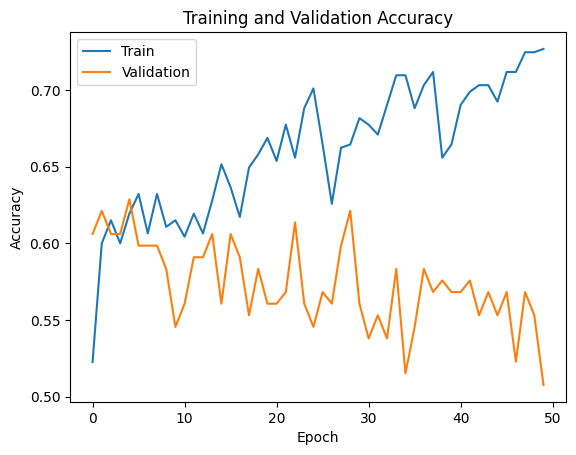

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation metrics
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Testing for Unseen Data.

In [ ]:
# Load the model with the highest validation accuracy
best_model = tf.keras.models.load_model('best_model.keras')

In [ ]:
!mkdir kvasir-valid
!wget --no-check-certificate 'https://pern-my.sharepoint.com/:u:/g/personal/m21f0034ai010_fecid_paf-iast_edu_pk/EeQQ4EsiCa9DqXpKH04T_lgB29wtQVSBnPvABYtFaVL8hw?e=YUkJIh&download=1' -O eshphagitis-severity-validation.zip
!unzip /content/eshphagitis-severity-validation.zip
!mv /content/content/eshphagitis-severity-validation /content/kvasir-valid
!rm -r /content/content

--2024-01-08 16:03:22--  https://pern-my.sharepoint.com/:u:/g/personal/m21f0034ai010_fecid_paf-iast_edu_pk/EeQQ4EsiCa9DqXpKH04T_lgB29wtQVSBnPvABYtFaVL8hw?e=YUkJIh&download=1
Resolving pern-my.sharepoint.com (pern-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to pern-my.sharepoint.com (pern-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/m21f0034ai010_fecid_paf-iast_edu_pk/Documents/MS%20AI/4-Spring%202023/Data/eshphagitis-severity-validation.zip?ga=1 [following]
--2024-01-08 16:03:22--  https://pern-my.sharepoint.com/personal/m21f0034ai010_fecid_paf-iast_edu_pk/Documents/MS%20AI/4-Spring%202023/Data/eshphagitis-severity-validation.zip?ga=1
Reusing existing connection to pern-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 47456989 (45M) [application/x-zip-compressed]
Saving to: ‘eshphagitis-severity-validation.zip’

eshphagitis-severit 100%[====

In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/kvasir-valid/eshphagitis-severity-validation',
    image_size=(299, 299),
    batch_size=16,
    shuffle=False,
)

In [19]:
# Extract true labels from the directory structure
true_labels = []
for images, labels in validation_dataset:
    true_labels.extend(labels.numpy())

# Convert to numpy array
true_labels = np.array(true_labels)

# Make predictions using the model on the validation dataset
predictions = best_model.predict(validation_dataset)

# Ensure the number of samples matches
num_samples_predictions = len(predictions)
num_samples_true_labels = len(true_labels)

if num_samples_predictions != num_samples_true_labels:
    print(f"Error: Mismatch in the number of samples - Predictions: {num_samples_predictions}, True Labels: {num_samples_true_labels}")
else:
    # Evaluate the model's performance
    from sklearn.metrics import accuracy_score, classification_report, f1_score

    predicted_labels = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"\nAccuracy: {accuracy}")

    f1 = f1_score(true_labels, predicted_labels)
    print(f"\nF1 Score: {f1}")

    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels))

5/5 [==============================] - 1s 122ms/step

Accuracy: 0.6212121212121212

F1 Score: 0.24242424242424246

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.93      0.75        40
           1       0.57      0.15      0.24        26

    accuracy                           0.62        66
   macro avg       0.60      0.54      0.49        66
weighted avg       0.61      0.62      0.55        66



In [ ]:
max_train_accuracy = max(history.history['accuracy'])
print('Maximum Training Accuracy:', max_train_accuracy)
max_val_accuracy = max(history.history['val_accuracy'])
print('Maximum Validation Accuracy:', max_val_accuracy)

Maximum Training Accuracy: 0.726881742477417
Maximum Validation Accuracy: 0.6287878751754761


In [ ]:
print("Training accuracy list:", history.history['accuracy'])
print("Validation accuracy list:", history.history['val_accuracy'])

Training accuracy list: [0.522580623626709, 0.6000000238418579, 0.6150537729263306, 0.6000000238418579, 0.6193548440933228, 0.6322580575942993, 0.6064516305923462, 0.6322580575942993, 0.6107527017593384, 0.6150537729263306, 0.6043010950088501, 0.6193548440933228, 0.6064516305923462, 0.6279569864273071, 0.6516128778457642, 0.6365591287612915, 0.6172043085098267, 0.6494623422622681, 0.6580645442008972, 0.6688172221183777, 0.6537634134292603, 0.6774193644523621, 0.6559139490127563, 0.6881720423698425, 0.7010752558708191, 0.6645161509513855, 0.625806450843811, 0.6623656153678894, 0.6645161509513855, 0.6817204356193542, 0.6774193644523621, 0.6709677577018738, 0.6903225779533386, 0.7096773982048035, 0.7096773982048035, 0.6881720423698425, 0.7032257914543152, 0.7118279337882996, 0.6559139490127563, 0.6645161509513855, 0.6903225779533386, 0.698924720287323, 0.7032257914543152, 0.7032257914543152, 0.6924731135368347, 0.7118279337882996, 0.7118279337882996, 0.7247312068939209, 0.7247312068939209